In [61]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import numpy as np
import scipy as scipy
from scipy.optimize import minimize
import shelve

BACKTEST = 3 # years, recommend at least 1~3 years
LOWER_BOUND = 0 #increase for diversification 
UPPER_BOUND = 0.4
NUM_OF_SIMULATIONS = 5000 #for monte carlo simulation
SEED = 1700000 #a principal of 1,300,000KRW
lambda_penalty = 0.5 #increase for robustness & diversificaiton, try 0.1 ~ 10

In [62]:
endDate = dt.datetime.today() + dt.timedelta(hours = 9) #한국 시간 기준
startDate = endDate - dt.timedelta(days = 365 * BACKTEST)

# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'NVDA', 'AVGO', 'WMT', 'LLY', 'JPM']
# tickers = ['379800.KS', '379810.KS', 'BTC-KRW', '047810.KS', '012450.KS', 'AAPL', 'MSFT', 'NVDA', 'GOOG', 'AMZN', 'META', 'BRK-B', 'AVGO', 'TSM', 'WMT', 'LLY', 'JPM']
tickers = []

with shelve.open("ticker_cache") as cache:
    for ticker, name in cache.items():
        tickers.append(ticker)


In [63]:
#stock = yf.Ticker("379800.KS") #개별주 시장가 확인
stock = yf.Ticker("KRW=X") #환율
price = stock.info['regularMarketPrice']
print(stock.info['currency'] + " " + str(price))

KRW 1358.6


In [64]:
adj_close_df = pd.DataFrame()

for ticker in tickers:
    data = yf.download(ticker, start = startDate, end = endDate)
    adj_close_df[ticker] = data['Close']

print(adj_close_df)

[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%*******

               005930.KS      090430.KS      086280.KS      009540.KS  \
Date                                                                    
2022-06-10  59655.523438  149663.671875   88569.007812   89988.945312   
2022-06-13  58065.957031  146240.000000   85171.218750   86764.585938   
2022-06-14  57878.941406  142816.312500   86077.296875   85494.382812   
2022-06-15  56756.898438  138903.546875   88115.968750   84028.765625   
2022-06-16  56943.902344  132056.187500   84944.710938   83931.054688   
2022-06-17  55915.355469  136458.046875   84265.148438   85885.218750   
2022-06-20  54886.820312  136458.046875   82226.476562   86373.757812   
2022-06-21  54699.812500  137925.359375   83359.070312   89500.406250   
2022-06-22  53858.273438  123741.539062   80187.804688   86764.585938   
2022-06-23  53671.261719  125208.835938   79281.718750   85494.382812   
2022-06-24  54606.304688  126676.125000   79961.273438   86080.632812   
2022-06-27  54980.324219  130588.906250   82226.476

In [65]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))
log_returns = log_returns.dropna()

In [66]:
cov_matrix = log_returns.cov() * 252
print(cov_matrix)

           005930.KS  090430.KS  086280.KS  009540.KS  326030.KS  011200.KS  \
005930.KS   0.108537   0.023391   0.041314   0.034914   0.040928   0.044676   
090430.KS   0.023391   0.278174   0.009717   0.031887   0.020864   0.045168   
086280.KS   0.041314   0.009717   0.163777   0.043875   0.023385   0.040912   
009540.KS   0.034914   0.031887   0.043875   0.251797   0.060421   0.060772   
326030.KS   0.040928   0.020864   0.023385   0.060421   0.198661   0.031563   
011200.KS   0.044676   0.045168   0.040912   0.060772   0.031563   0.185150   
272210.KS   0.018428   0.002868   0.023834   0.126847   0.038788   0.022849   
267260.KS   0.048434   0.006788   0.051902   0.107707   0.050588   0.045942   
012330.KS   0.027866   0.015613   0.070378   0.033211   0.024015   0.033389   
005385.KS   0.039718   0.017091   0.048849   0.035123   0.026355   0.020681   
012450.KS   0.030402   0.004185   0.030245   0.077309   0.053618   0.033892   
443060.KS   0.029515   0.043690   0.027756   0.12410

In [67]:
def standard_deviation (weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [68]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean() * weights)*252

In [69]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return (expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [70]:
from fredapi import Fred
#https://fredaccount.stlouisfed.org/apikey
fred = Fred(api_key = '34e4735c415e19669e7094dbd83af34f')
ten_year_treasury_rate = fred.get_series_latest_release('GS10') / 100

risk_free_rate = ten_year_treasury_rate[-1]
# print(risk_free_rate)

/tmp/ipykernel_4217/3437368303.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  risk_free_rate = ten_year_treasury_rate[-1]


In [71]:
#핵심
#OPTIMIZE the portfolio using different techniques here like
# monte carlo simulation, mathematical optimization, etc
# other alternatives include black-litterman model, min variance, 
# max diversification/risk pairty, 

def neg_sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio(weights, log_returns, cov_matrix, risk_free_rate) + (lambda_penalty * np.sum(weights**2))

constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}

#say you wanna fix AVGO's weight to be exactly 0.25. if you want it to be at least 0.25, change 'eq' to 'ineq'
# constraints = [{'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}, 
#               {'type': 'eq', 'fun': lambda weights: weights[tickers.index('379800.KS')] - 0.75}]
bounds = [(LOWER_BOUND, UPPER_BOUND) for _ in range(len(tickers))]
initial_weights = np.array([1/len(tickers)]*len(tickers))

In [72]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [73]:
optimal_weights = optimized_results.x #.x gets the results

In [74]:
# print("Optimal Weights:")
# for ticker, weight in zip(tickers, optimal_weights):
#     print(f"{ticker}: {weight:.4f}")

# optimal_portfolio_return = expected_return(optimal_weights, log_returns)
# optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
# optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

# print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
# print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
# print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

In [75]:
import matplotlib.pyplot as plt

# plt.figure(figsize=(10, 6))
# plt.bar(tickers, optimal_weights)

# plt.xlabel('Assets')
# plt.ylabel('Optimal Weights')
# plt.title('Optimal Portfolio Weights')

# plt.show()

In [76]:
# Initialize the components, to run a Monte Carlo Simulation.
number_of_symbols = len(tickers)
# We will run 5000 iterations.
num_of_portfolios = NUM_OF_SIMULATIONS

float_formatter = "{:.2f}".format

# Prep an array to store the weights as they are generated, 5000 iterations for each of our 4 symbols.
all_weights = np.zeros((num_of_portfolios, number_of_symbols))

# Prep an array to store the returns as they are generated, 5000 possible return values.
ret_arr = np.zeros(num_of_portfolios)

# Prep an array to store the volatilities as they are generated, 5000 possible volatility values.
vol_arr = np.zeros(num_of_portfolios)

# Prep an array to store the sharpe ratios as they are generated, 5000 possible Sharpe Ratios.
sharpe_arr = np.zeros(num_of_portfolios)

# Start the simulations.
for ind in range(num_of_portfolios):

    # First, calculate the weights.
    weights = np.array(np.random.random(number_of_symbols))
    weights = weights / np.sum(weights)

    # Add the weights, to the `weights_arrays`.
    all_weights[ind, :] = weights

    # Calculate the expected log returns, and add them to the `returns_array`.
    ret_arr[ind] = np.sum((log_returns.mean() * weights) * 252)

    # Calculate the volatility, and add them to the `volatility_array`.
    vol_arr[ind] = np.sqrt(
        np.dot(weights.T, np.dot(log_returns.cov() * 252, weights))
    )

    # Calculate the Sharpe Ratio and Add it to the `sharpe_ratio_array`.
    sharpe_arr[ind] = ret_arr[ind]/vol_arr[ind]

# Let's create our "Master Data Frame", with the weights, the returns, the volatility, and the Sharpe Ratio

simulations_data = [ret_arr, vol_arr, sharpe_arr, np.round(all_weights, 4)]
# Create a DataFrame from it, then Transpose it so it looks like our original one.
simulations_df = pd.DataFrame(data=simulations_data).T

data = {
    'Portfolio Weights': [
        np.random.rand(10).tolist() for _ in range(5000)
    ]
}
df = pd.DataFrame(data)

# Set Pandas to display all columns and rows
pd.set_option('display.max_rows', None)  # To display all rows
pd.set_option('display.max_columns', None)  # To display all columns
pd.set_option('display.max_colwidth', None)  # To prevent truncation of column values

# Give the columns the Proper Names.
simulations_df.columns = [
    'Returns',
    'Volatility',
    'Sharpe Ratio',
    'Portfolio Weights'
]

# Make sure the data types are correct, we don't want our floats to be strings.
simulations_df = simulations_df.infer_objects()

# Print out the results.
MAX_LINE = 100
# print('')
# print('='*MAX_LINE)
# print('SIMULATIONS RESULT:')
# print('-'*MAX_LINE)
# with np.printoptions(threshold=sys.maxsize):
#     print(simulations_df)
# print('-'*MAX_LINE)

In [77]:
# Return the Max Sharpe Ratio from the run.
max_sharpe_ratio = simulations_df.loc[simulations_df['Sharpe Ratio'].idxmax()]
monte_carlo_max_sharpe_weights = max_sharpe_ratio.loc['Portfolio Weights']
# Return the Min Volatility from the run.
min_volatility = simulations_df.loc[simulations_df['Volatility'].idxmin()]
monte_carlo_min_vol_weights = min_volatility.loc['Portfolio Weights']

print('')
print('='*MAX_LINE)
print('MAX SHARPE RATIO:')
print('-'*MAX_LINE)
print(max_sharpe_ratio)
print('-'*MAX_LINE)

print('')
print('='*MAX_LINE)
print('MIN VOLATILITY:')
print('-'*MAX_LINE)
print(min_volatility)
print('-'*MAX_LINE)


MAX SHARPE RATIO:
----------------------------------------------------------------------------------------------------
Returns                                                                                                                                                                                                         0.63761
Volatility                                                                                                                                                                                                     0.280176
Sharpe Ratio                                                                                                                                                                                                   2.275746
Portfolio Weights    [0.0073, 0.0017, 0.0389, 0.08, 0.0255, 0.0502, 0.0844, 0.0479, 0.0254, 0.0121, 0.0571, 0.0337, 0.0059, 0.0584, 0.0781, 0.0505, 0.0859, 0.0758, 0.0058, 0.039, 0.008, 0.0458, 0.036, 0.005, 0.0414]
Name: 1485, dtyp

Re-reun SLSQP Optimization with weights from Monte Carlo simulation as initial guess to land a global Sharpe Maximum and enhance results

In [78]:
optimized_results_max_sharpe = minimize(neg_sharpe_ratio, monte_carlo_max_sharpe_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)
optimized_results_min_vol = minimize(neg_sharpe_ratio, monte_carlo_min_vol_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [79]:
optimal_weights = optimized_results_max_sharpe.x
threshold = 10e-4

# print(optimal_weights)
# optimal_weights = optimized_results_min_vol.x

print("Optimal Weights (최적화 가중치):")
print("원금: " + f"{SEED:,}"+ "원. 백테스팅 기간: " + F"{BACKTEST}" + "년")
for ticker, weight in zip(tickers, optimal_weights):
    if weight >= threshold:
        num = round(SEED * weight)
        with shelve.open("ticker_cache") as cache:
            print(f"{ticker}({cache[ticker]}): {weight:.4f}" + ", 투자금액: " +  str(f"{num:,}") + "원")

optimal_portfolio_return = expected_return(optimal_weights, log_returns)
optimal_portfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected Annual Return: {optimal_portfolio_return:.4f}")
print(f"Expected Volatility: {optimal_portfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_sharpe_ratio:.4f}")

Optimal Weights (최적화 가중치):
원금: 1,700,000원. 백테스팅 기간: 3년
086280.KS(Hyundai Glovis Co., Ltd.): 0.0308, 투자금액: 52,423원
009540.KS(HD Korea Shipbuilding & Offshore Engineering Co., Ltd.): 0.1332, 투자금액: 226,453원
012450.KS(Hanwha Aerospace Co., Ltd.): 0.1185, 투자금액: 201,424원
064350.KS(Hyundai Rotem Company): 0.1587, 투자금액: 269,775원
003230.KS(Samyang Foods Co., Ltd.): 0.2243, 투자금액: 381,352원
024110.KS(Industrial Bank of Korea): 0.0693, 투자금액: 117,780원
000720.KS(Hyundai Engineering & Construction Co.,Ltd.): 0.1785, 투자금액: 303,425원
259960.KS(KRAFTON, Inc.): 0.0867, 투자금액: 147,368원
Expected Annual Return: 0.9427
Expected Volatility: 0.3032
Sharpe Ratio: 2.9629


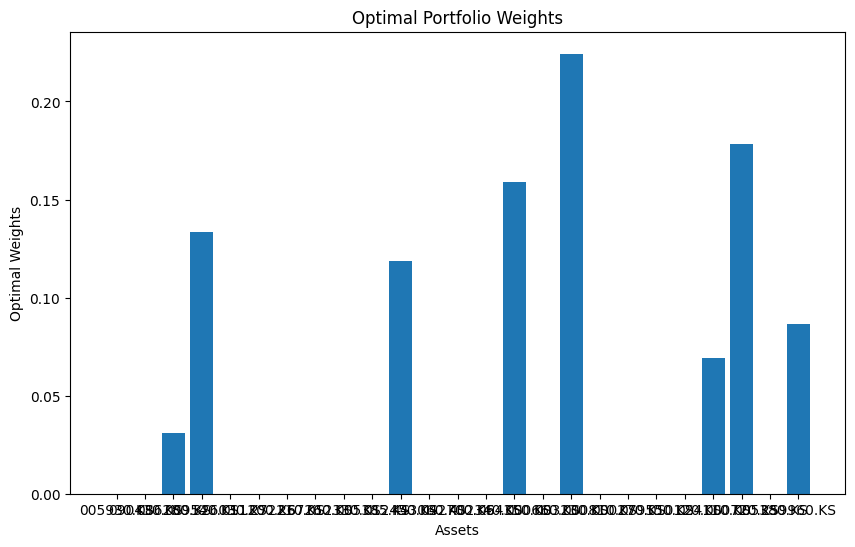

In [80]:
plt.figure(figsize=(10, 6))
plt.bar(tickers, optimal_weights)

plt.xlabel('Assets')
plt.ylabel('Optimal Weights')
plt.title('Optimal Portfolio Weights')

plt.show()